In [86]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

from statsmodels.stats.multitest import multipletests

# Define experiments

In [87]:
experiments = {"rpl22_oe": [
    ['LNCaP_GFP_1',
     'LNCaP_GFP_2',
     'LNCaP_GFP_3'],
    ['LNCaP_RPL22_1',
     'LNCaP_RPL22_2',
     'LNCaP_RPL22_3']
],
    "rpl22l1_oe": [
    ['CAL851_GFP_1',
     'CAL851_GFP_2',
     'CAL851_GFP_3'],
    ['CAL851_RPL22L1_1',
     'CAL851_RPL22L1_2',
     'CAL851_RPL22L1_3']
],
    "sh704": [
    ['LNCaP_shLuc_1',
     'LNCaP_shLuc_2',
     'LNCaP_shLuc_3'],
    ['LNCaP_sh704_1',
     'LNCaP_sh704_2',
     'LNCaP_sh704_3']
],
    "sh705": [
    ['LNCaP_shLuc_1',
     'LNCaP_shLuc_2',
     'LNCaP_shLuc_3'],
    ['LNCaP_sh705_1',
     'LNCaP_sh705_2',
     'LNCaP_sh705_3']
]
}

experiment_ids = ["rpl22_oe","rpl22l1_oe","sh704","sh705"]

# Load TPMS and sleuth results

In [102]:
kallisto_sleuth_path = "../data/processed/kallisto_sleuth_merge/"

rpl22_oe_genes = pd.read_csv(kallisto_sleuth_path + "rpl22_oe_genes.txt", sep="\t", index_col=0)
rpl22l1_oe_genes = pd.read_csv(kallisto_sleuth_path + "rpl22l1_oe_genes.txt", sep="\t", index_col=0)
sh704_genes = pd.read_csv(kallisto_sleuth_path + "sh704_genes.txt", sep="\t", index_col=0)
sh705_genes = pd.read_csv(kallisto_sleuth_path + "sh705_genes.txt", sep="\t", index_col=0)

rpl22_oe_transcripts = pd.read_csv(kallisto_sleuth_path + "rpl22_oe_transcripts.txt", sep="\t", index_col=0)
rpl22l1_oe_transcripts = pd.read_csv(kallisto_sleuth_path + "rpl22l1_oe_transcripts.txt", sep="\t", index_col=0)
sh704_transcripts = pd.read_csv(kallisto_sleuth_path + "sh704_transcripts.txt", sep="\t", index_col=0)
sh705_transcripts = pd.read_csv(kallisto_sleuth_path + "sh705_transcripts.txt", sep="\t", index_col=0)

# Differential expression

In [103]:
def as_si(x, ndp):
    """
    Convert a number to scientific notation

    Parameters
    ----------
    x : float
        number to convert
    ndp: float
        number of decimal places

    Returns
    -------
    x_si : string
        x formatted in scientific notation
    """

    s = '{x:0.{ndp:d}e}'.format(x=x, ndp=ndp)
    m, e = s.split('e')
    x_si = r'{m:s} × $10^{{{e:d}}}$'.format(m=m, e=int(e))

    return x_si

In [116]:
control_color = "grey"
treatment_color = "red"
alpha = 0.5


def plot_tpm_dist(transcript_id, experiment_id, diff_results, ax=None, pal=None, xlabel=None, ylabel=None):

    if ax is None:
        ax = plt.subplot(111)

    if pal is None:
        pal = sns.color_palette([control_color, treatment_color])

    if xlabel is None:
        xlabel = experiment_id

    if ylabel is None:
        ylabel = "mRNA expression, log2(TPM + 1)"

    select_abundance = diff_results.loc[transcript_id]

    controls = experiments[experiment_id][0]
    treatments = experiments[experiment_id][1]

    tpms = np.log2(select_abundance[controls+treatments].astype(np.float64)+1)

    expression_df = pd.DataFrame(index=controls+treatments)

    expression_df["tpm"] = tpms
    expression_df["treatment"] = ["control"] * \
        len(controls)+["treatment"]*len(treatments)

    sns.swarmplot(x="treatment",
                  y="tpm",
                  data=expression_df,
                  ax=ax,
                  palette=pal,
                  s=6,
                  alpha=1,
                  edgecolor="black",
                  )

    sns.barplot(x="treatment",
                y="tpm",
                data=expression_df,
                ax=ax,
                palette=pal,
                alpha=alpha/2,
                linewidth=1,
                ci=None
                )

    means = expression_df.groupby("treatment")["tpm"].mean()

    ax.axhline(means["control"], 0.1, 0.4,
               linewidth=1, color="black", zorder=100)
    ax.axhline(means["treatment"], 0.6, 0.9,
               linewidth=1, color="black", zorder=100)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xticks([])
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    ax.spines['bottom'].set_position(('axes', -0.05))
    ax.spines['left'].set_position(('axes', -0.05))

    plt.ylim(0)

    y_max = max(tpms)

    if not np.isnan(select_abundance["qval"]):

        qval = as_si(select_abundance["qval"], 0)
        ax.text(0.5, y_max*1.2, qval, ha="center", fontsize=8)

    return ax, y_max


def plot_tpm_dist_all(annotation_id,annotation_type):

    f, axes = plt.subplots(1, 4, sharey=True, figsize=(4, 3))

    maxes = []
    
    if annotation_type == "transcript":

        sleuth_sets = [rpl22_oe_transcripts,
                       rpl22l1_oe_transcripts,
                       sh704_transcripts,
                       sh705_transcripts
                       ]
        
    elif annotation_type == "gene":
        
        sleuth_sets = [rpl22_oe_genes,
                       rpl22l1_oe_genes,
                       sh704_genes,
                       sh705_genes
                       ]

    for sleuth_idx, sleuth_set in enumerate(sleuth_sets):
        ax = axes[sleuth_idx]
        
        ax, y_max = plot_tpm_dist(annotation_id, 
                                  experiment_ids[sleuth_idx], 
                                  sleuth_set, 
                                  ax=ax, 
                                  ylabel="")
        
        maxes.append(y_max)
    
        if sleuth_idx > 0:
    
            ax.spines["left"].set_visible(False)
            ax.tick_params(axis='y', which='both', right=False,
                           left=False, labelleft=False)
            
    axes[0].set_xlabel("RPL22++")
    axes[1].set_xlabel("RPL22L1++")
    

    plt.ylim(-0.1, max(maxes)*1.25)

    plt.subplots_adjust(wspace=0.4)

    legend_elements = [Line2D([0], [0], marker='o', color="white", label='Control',
                              markerfacecolor=control_color, markersize=8, alpha=alpha),
                       Line2D([0], [0], marker='o', color="white", label='Treatment',
                              markerfacecolor=treatment_color, markersize=8, alpha=alpha)]

    plt.legend(handles=legend_elements,
               loc='upper left', bbox_to_anchor=(1, 1))

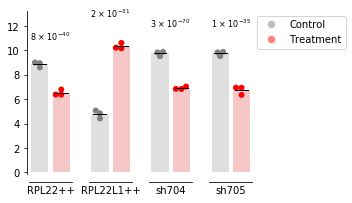

In [117]:
plot_tpm_dist_all("ENST00000463836","transcript")

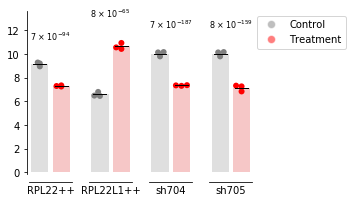

In [120]:
plot_tpm_dist_all("ENSG00000163584","gene")

## Volcano plots

In [96]:
def compute_medians(sleuth_diff, experiment):
    sleuth_diff["control_median"] = sleuth_diff[experiments[experiment][0]].median(axis=1)
    sleuth_diff["treatment_median"] = sleuth_diff[experiments[experiment][1]].median(axis=1)
    sleuth_diff["median_foldchange"] = sleuth_diff["treatment_median"]/sleuth_diff["control_median"]

In [97]:
compute_medians(rpl22_oe_genes,"rpl22_oe")
compute_medians(rpl22l1_oe_genes,"rpl22l1_oe")
compute_medians(sh704_genes,"sh704")
compute_medians(sh705_genes,"sh705")

compute_medians(rpl22_oe_transcripts,"rpl22_oe")
compute_medians(rpl22l1_oe_transcripts,"rpl22l1_oe")
compute_medians(sh704_transcripts,"sh704")
compute_medians(sh705_transcripts,"sh705")

# Differential splicing

In [26]:
rpl22_oe_rmats = pd.read_csv("../data/processed/rmats_merge/rpl22_oe.txt",sep="\t")
rpl22l1_oe_rmats = pd.read_csv("../data/processed/rmats_merge/rpl22l1_oe.txt",sep="\t")
sh704_rmats = pd.read_csv("../data/processed/rmats_merge/sh704.txt",sep="\t")
sh705_rmats = pd.read_csv("../data/processed/rmats_merge/sh705.txt",sep="\t")

In [27]:
def plot_psi_dist(exon_id, experiment_id, diff_results, ax=None, pal=None, xlabel=None, ylabel=None):

    if ax is None:
        ax = plt.subplot(111)

    if pal is None:
        pal = sns.color_palette([control_color, treatment_color])

    if xlabel is None:
        xlabel = experiment_id

    if ylabel is None:
        ylabel = "mRNA expression, log2(TPM + 1)"

    select_abundance = diff_results.loc[exon_id]

    controls = experiments[experiment_id][0]
    treatments = experiments[experiment_id][1]

    tpms = np.log2(select_abundance[controls+treatments].astype(np.float64)+1)

    expression_df = pd.DataFrame(index=controls+treatments)

    expression_df["tpm"] = tpms
    expression_df["treatment"] = ["control"] * \
        len(controls)+["treatment"]*len(treatments)

    sns.swarmplot(x="treatment",
                  y="tpm",
                  data=expression_df,
                  ax=ax,
                  palette=pal,
                  s=6,
                  alpha=alpha,
                  linewidth=1,
                  edgecolor="black",
                  )
    
    means = expression_df.groupby("treatment")["tpm"].mean()
    
    ax.axhline(means["control"], 0.15,0.35, linewidth=2, color="black", zorder=100)
    ax.axhline(means["treatment"], 0.65,0.85, linewidth=2, color="black", zorder=100)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xticks([])
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    ax.spines['bottom'].set_position(('axes', -0.05))
    ax.spines['left'].set_position(('axes', -0.05))
    
    plt.ylim(0)
    
    y_max = max(tpms)
    
    if not np.isnan(select_abundance["qval"]):
    
        qval = as_si(select_abundance["qval"],0)
        ax.text(0.5, y_max*1.2, qval,ha="center",fontsize=8)

    return ax, y_max
